#################################
# Airline Passenger Forecasting
#################################

In [55]:
# Kütüphanelerimizi import edelim;

import itertools
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

In [56]:
# Verimizi okutalım;

df = pd.read_csv('datasets/airline-passengers.csv', index_col='month', parse_dates=True)

# "index_col=" argümanı ile indeksin hangi değişken olacağını seçiyoruz.
# "parse_dates=" argümanı ile de tarih verisini (default olarak python tarih verisini object olarak görür),
# belirle ve onu tarih verisi olarak değiştir diyoruz.

df.head()

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   total_passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


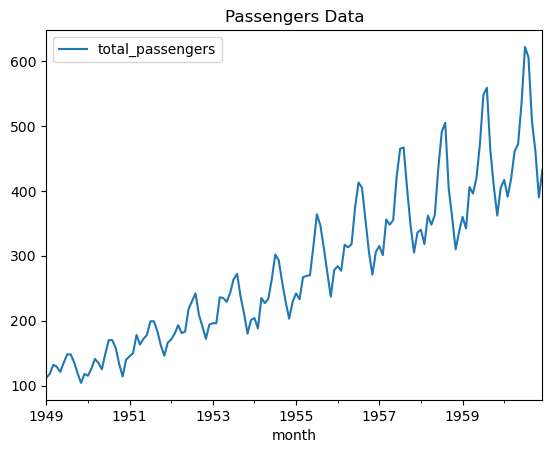

In [58]:
# Verimizi görselleştirelim;

df[['total_passengers']].plot(title='Passengers Data')
plt.show()

    Veri de hem trend hem de mevsimsellik var. Dolayısıyla veri durağan değildir.

In [59]:
# Verimizin indekslerine bakalım;

df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

#### Verimiz aylık bunu görebiliyoruz lakin, bunu python'a da bildirelim.

In [60]:
# Veri frekansını ekleyelim;
df.index.freq = "MS"

# Veri frekansımıza bir kez daha bakalım;
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq='MS')

In [61]:
# Verimizi train ve test olarak bölelim;

train = df[:120]
test = df[120:]

In [62]:
# Görselleştirme fonksiyonumuzu tanımlayalım;

# Fonksiyon bu çalışma için oluşturulmuştur !!!

def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

In [63]:
#################################
# Single Exponential Smoothing
#################################

# optimazer fonksiyonumuzu tanımlayalım;
def ses_optimizer(train, alphas, step=10):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

# Alpha aralığımızı tanımlayalım;
alphas = np.arange(0.01, 1, 0.10)

# Best alphayı arayalım;
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)

alpha: 0.01 mae: 190.1198
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


In [64]:
# Final modelini tanımlayalım ve önümüzdeki 24 döneme ilişkin tahminde bulunalım;
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

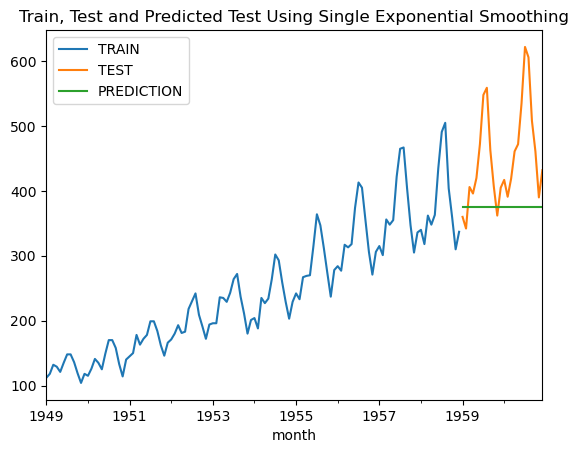

In [65]:
# Grafiğimizi çizdirelim;

plot_prediction(y_pred, "Single Exponential Smoothing")

    Çok kötü tahminlerde bulunduk.

In [66]:
#################################
# Double Exponential Smoothing
#################################

# optimazer fonksiyonumuzu tanımlayalım;
def des_optimizer(train, alphas, betas, step=10):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

# alpha ve beta için aralık atayalım;
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

# Best alpha ve betayı arayalım;
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)

alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5568
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9637
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8984
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

In [67]:
# Final modelini tanımlayalım ve önümüzdeki 24 döneme ilişkin tahminde bulunalım;
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta) 
y_pred = des_model.forecast(24)

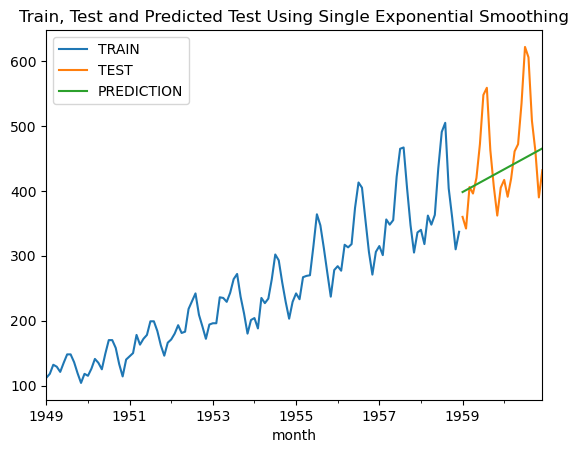

In [68]:
# Grafiğimizi çizdirelim;

plot_prediction(y_pred, "Single Exponential Smoothing")

    Hala istediğimiz noktada değiliz.

In [69]:
#################################
# Triple Exponential Smoothing (Holt-Winters)
#################################

# optimazer fonksiyonumuzu tanımlayalım;

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

# alpha, beta ve gamma için aralık atayalım;
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

# Best alpha, beta ve gammayı arayalım;
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.76]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

In [70]:
# Final modelini tanımlayalım ve önümüzdeki 24 döneme ilişkin tahminde bulunalım;
tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = tes_model.forecast(24)

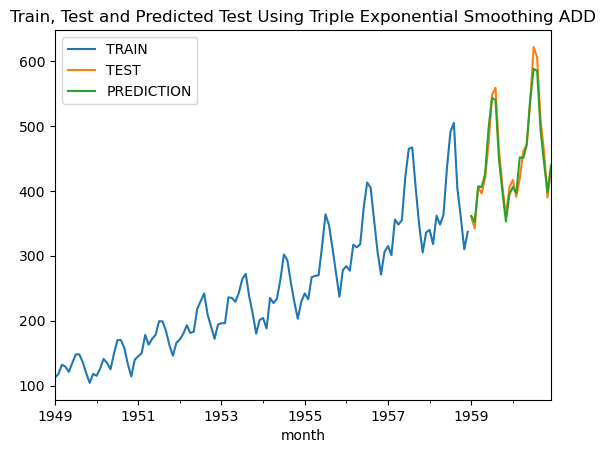

In [71]:
# Grafiğimizi çizdirelim;

plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

    Holt-Winters en iyi MAE'yi verdi. En iyi tahmini de TES ile yaptığımızı grafikten görebiliyoruz.

In [72]:
# Peki modelimizi çarpımsal olarak kurarsak ne olur, onu inceleyelim;
tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = tes_model.forecast(24)

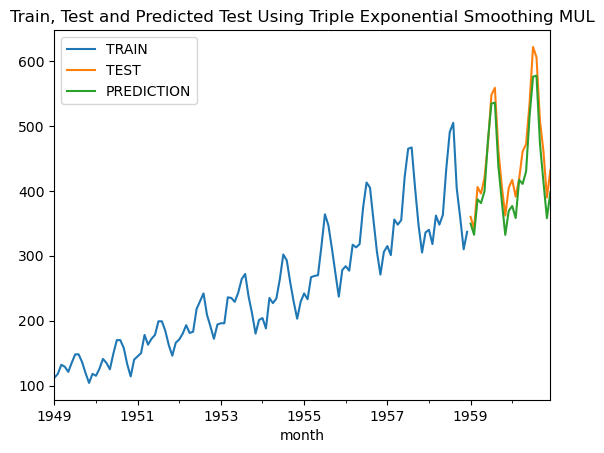

In [73]:
# Grafiği görselleştirelim;

plot_prediction(y_pred, "Triple Exponential Smoothing MUL")

    Grafik üzerinden görüyoruz ki multiplicative model, additive modelden daha kötü tahminde bulunmuş. Zira dikatli bakıldığında sapmaların daha fazla olduğu görülebilir.

    Dilerseniz optimazer fonksiyonu üzerinde de değişiklik yaparak bunu kontrol edebilirsiniz.

In [74]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################

In [75]:
# ARIMA modeli için hiper parametrelerimizi oluşturalım;

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 3, 0),
 (3, 3, 1),
 (3, 3, 2),
 (3, 3, 3)]

In [80]:
# ARIMA optimaser tanımlayalım;

def arima_optimizer_mae(train, orders):
    best_mae, best_params = float("inf"), None
    for i in orders:
        try:
            arma_model_result = ARIMA(train, order=i).fit()
            y_pred = arma_model_result.forecast(24)            
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_params = mae, i
            print('ARIMA%s MAE=%.2f' % (i, mae))
        except:
            continue
    print('Best ARIMA%s MAE=%.2f' % (best_params, best_mae))
    return best_params

best_params_mae = arima_optimizer_mae(train, pdq)

ARIMA(0, 0, 0) MAE=206.34
ARIMA(0, 0, 1) MAE=201.95
ARIMA(0, 0, 2) MAE=204.81
ARIMA(0, 0, 3) MAE=199.63
ARIMA(0, 1, 0) MAE=115.25
ARIMA(0, 1, 1) MAE=99.12
ARIMA(0, 1, 2) MAE=94.86
ARIMA(0, 1, 3) MAE=82.27
ARIMA(0, 2, 0) MAE=224.58
ARIMA(0, 2, 1) MAE=91.66
ARIMA(0, 2, 2) MAE=76.32
ARIMA(0, 2, 3) MAE=72.46
ARIMA(0, 3, 0) MAE=8455.58
ARIMA(0, 3, 1) MAE=242.97
ARIMA(0, 3, 2) MAE=107.11
ARIMA(0, 3, 3) MAE=99.97
ARIMA(1, 0, 0) MAE=153.70
ARIMA(1, 0, 1) MAE=157.25
ARIMA(1, 0, 2) MAE=148.24
ARIMA(1, 0, 3) MAE=152.67
ARIMA(1, 1, 0) MAE=105.03
ARIMA(1, 1, 1) MAE=93.90
ARIMA(1, 1, 2) MAE=82.67
ARIMA(1, 1, 3) MAE=82.82
ARIMA(1, 2, 0) MAE=84.44
ARIMA(1, 2, 1) MAE=81.70
ARIMA(1, 2, 2) MAE=71.50
ARIMA(1, 2, 3) MAE=69.90
ARIMA(1, 3, 0) MAE=5454.41
ARIMA(1, 3, 1) MAE=91.37
ARIMA(1, 3, 2) MAE=387.06
ARIMA(1, 3, 3) MAE=81.65
ARIMA(2, 0, 0) MAE=164.33
ARIMA(2, 0, 1) MAE=146.27
ARIMA(2, 0, 2) MAE=150.55
ARIMA(2, 0, 3) MAE=92.85
ARIMA(2, 1, 0) MAE=99.69
ARIMA(2, 1, 1) MAE=75.66
ARIMA(2, 1, 2) MAE=69.10
ARIM

In [84]:
# Best hiperparametreler ile modelimzi yeniden kuralım;
arima_model = ARIMA(train, order = best_params_mae).fit()

# Tahminde bulunalım;
y_pred = arima_model.forecast(24)

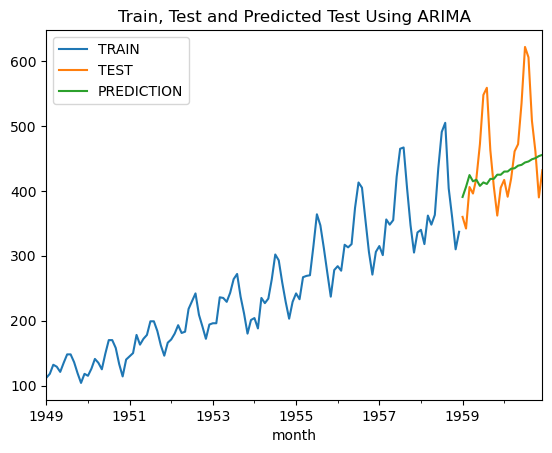

In [85]:
# Grafiğimizi çizdirelim;

plot_prediction(pd.Series(y_pred, index=test.index), "ARIMA")

In [86]:
##################################################
# SARIMA
##################################################

In [87]:
# SARIMA modeli için hiper parametrelerimzi oluşturalım;

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [93]:
# MAE için optimise edecek bir fonksiyon tanımlayalım;

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [94]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.20954423850617
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.629726375625
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93624732229098
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79710434035235
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.59973872742848
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.65126215748084
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260551
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.2897856674699
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.49252848025027
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051671286865
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.48454461453615
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43305373977557
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.01388544131246
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.854639154140653
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368421542572
SARIMA(0, 1, 0)x(0, 1, 0,

In [95]:
# Best hiperparametreler ile modelimzi yeniden kuralım;
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)

# SARIMA modelimizi eğitelim;
sarima_final_model = model.fit(disp=0)

# sonraki 24 dönemi tahmin edelim;
y_pred_test = sarima_final_model.get_forecast(steps=24)

# Tahmin değerlerimize erişelim;
y_pred = y_pred_test.predicted_mean

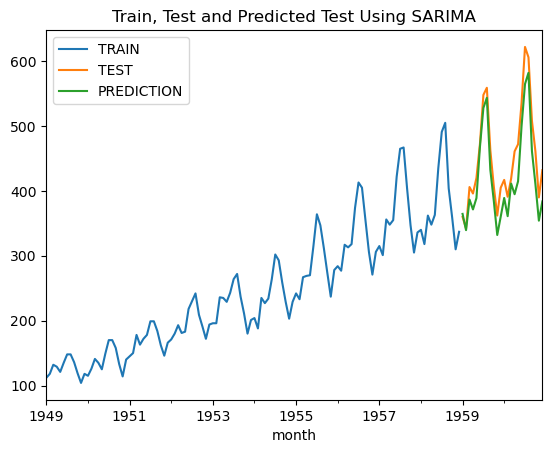

In [96]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

# Final Model

    En az MAE değerine Holt-Winters metodunda ulaştık, bu sebeple TES metodunu getirelim.

In [97]:
# Model nesnemizi çağıralım ve içerisine hiper parametre ve argümanlarımızı girelim;

tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [98]:
# Önümüzdeki 6 dönemi forecast edelim;

tes_model_final.forecast(6)

1961-01-01    450.286337
1961-02-01    429.302021
1961-03-01    475.721710
1961-04-01    502.017552
1961-05-01    516.825550
1961-06-01    579.037154
Freq: MS, dtype: float64